# 2D plotting of LES output vs. satellite imagery (work in progress)
* The below notebook compares selected simulations against observational targets that were collected from satellite and ground-based retrievals.
* In case of questions or concerns, please notify Ann Fridlind (ann.fridlind@nasa.gov), Timothy Juliano (tjuliano@ucar.edu), and Florian Tornow (ft2544@columbia.edu).

In [181]:

import glob, os
import geopy
import geopy.distance

os.getcwd()


'/user-data-home/comble-mip/notebooks/plotting'

In [168]:
os.chdir("/user-data-home/comble-mip/notebooks/plotting/")

%run functions_plotting.py 
%run function_plotting_2d.py 

## read trajectory
ds = nc.Dataset('../../data_files/theta_temp_rh_sh_uvw_sst_along_trajectory_era5ml_28h_end_2020-03-13-18.nc')
les_time = 18. + ds['Time'][:]
    
## select simulations to plot
sim_keyword = 'FixN_2D'  

In [3]:
## select times
Time_Vec = [0.,1.,2.,6.,10.,14.,18.] ## hours, where 18 h marks arrival

## select acceptable window of time
Time_Window = 15.0  ## hours

## set domain to be extracted
Spat_Window = 100.0 ## km


In [4]:
## convert to regular time
tprop = []
for toi in Time_Vec:
    tprop.append(np.datetime64('2020-03-13T00:00:00') + np.timedelta64(int(toi),'h'))
           

In [5]:
## load satellite imagery

os.chdir("/data/project/comble-mip/satellite_imagery/viirs/")
counter_dat = 0
for file in glob.glob("*03DNB*.nc"):
    
    ## load geolocation    
    ds_geo = nc.Dataset("/data/project/comble-mip/satellite_imagery/viirs/" + file)
    
    ## load imagery
    file_sp = file.split('.')    
    file_img = glob.glob(file_sp[0].replace('3','2')+'.'+file_sp[1]+'.'+file_sp[2]+'*')[0]
    ds_img = nc.Dataset("/data/project/comble-mip/satellite_imagery/viirs/" + file_img)
    
    ## time
    file_time = np.datetime64('2020-01-01') + np.timedelta64(int(file_sp[1][5:8])-1,'D') + np.timedelta64(int(file_sp[2][0:2]),'h')+ np.timedelta64(int(file_sp[2][2:4]),'m')
    
    print(file)
    print(file_img)    
    
    ## for each requested model timestep, check if image covers right place at right time
    counter_time = 0
    for Time_OI in tprop:
        diff_time = (file_time - np.datetime64(Time_OI))/np.timedelta64(1, 's')/3600
        if np.abs(diff_time) <= Time_Window:
            print(Time_OI)
            Traj_time = (Time_OI - np.datetime64('2020-03-13T18:00:00'))/np.timedelta64(1, 's')/3600
            Lat_OI = ds['Latitude'][ds['Time'][:]==Traj_time][0]
            Lon_OI = ds['Longitude'][ds['Time'][:]==Traj_time][0]
            
            ## create spatial window around coordinate of interest
            start = geopy.Point(Lat_OI, Lon_OI)
            d = geopy.distance.distance(kilometers=1.2*Spat_Window/2)
            
            LAT_MIN = d.destination(point=start, bearing=180)[0]
            LAT_MAX = d.destination(point=start, bearing=0)[0]
            LON_MIN = d.destination(point=start, bearing=270)[1]
            LON_MAX = d.destination(point=start, bearing=90)[1]
            
            ## select pixels within window
            pix_num = ((ds_geo['geolocation_data/latitude'][:] > LAT_MIN) & 
                       (ds_geo['geolocation_data/latitude'][:] < LAT_MAX) & 
                       (ds_geo['geolocation_data/longitude'][:] > LON_MIN)& 
                       (ds_geo['geolocation_data/longitude'][:] < LON_MAX)).sum()
            print(pix_num)
            
            if pix_num > 0:
                
                ds_sub = ds_img['observation_data/DNB_observations'][:,:][(ds_geo['geolocation_data/latitude'][:] > LAT_MIN) & 
                                                                          (ds_geo['geolocation_data/latitude'][:] < LAT_MAX) & 
                                                                          (ds_geo['geolocation_data/longitude'][:] > LON_MIN)& 
                                                                          (ds_geo['geolocation_data/longitude'][:] < LON_MAX)]
                ds_lat = ds_geo['geolocation_data/latitude'][:,:][(ds_geo['geolocation_data/latitude'][:] > LAT_MIN) & 
                                                                  (ds_geo['geolocation_data/latitude'][:] < LAT_MAX) & 
                                                                  (ds_geo['geolocation_data/longitude'][:] > LON_MIN)& 
                                                                  (ds_geo['geolocation_data/longitude'][:] < LON_MAX)]
                ds_lon = ds_geo['geolocation_data/longitude'][:,:][(ds_geo['geolocation_data/latitude'][:] > LAT_MIN) & 
                                                                   (ds_geo['geolocation_data/latitude'][:] < LAT_MAX) & 
                                                                   (ds_geo['geolocation_data/longitude'][:] > LON_MIN)& 
                                                                   (ds_geo['geolocation_data/longitude'][:] < LON_MAX)]
                da = xr.DataArray(
                    name = 'alb',
                    data = ds_sub,
                    dims = ['pixel'],
                    coords = dict(
                        lon = (['pixel'],ds_lon),
                        lat = (['pixel'],ds_lat)
                    ))
            
                ## compute meridional and latitudal distance to center
                da['x_dist'] = 0*da['lat']
                da['y_dist'] = 0*da['lat']
                for ii in range(len(ds_sub)):
                    da['x_dist'][ii] = geopy.distance.geodesic((da['lat'][ii],da['lon'][ii]), 
                                                               (da['lat'][ii],Lon_OI)).km * np.sign((da['lon'][ii].data - Lon_OI))
                    da['y_dist'][ii] = geopy.distance.geodesic((da['lat'][ii],da['lon'][ii]), 
                                                               (Lat_OI,da['lon'][ii])).km * np.sign((da['lat'][ii].data - Lat_OI)) 
                
                ## limit to requested size
                da = da[np.abs(da['x_dist']) <= Spat_Window/2]
                da = da[np.abs(da['y_dist']) <= Spat_Window/2]
                
                ## normalize radiance values to resemble LES pseudo-albedo
                da.data = ((da.data - da.data.min())/(da.data.max() - da.data.min()))*0.8
                    
                da['x_round'] = np.round(da['x_dist'])
                da['y_round'] = np.round(da['y_dist'])
                
                for yy in np.unique(da['y_round']):
                    da_sub = da[da['y_round'] == yy]
                    da_stat = da_sub.groupby('x_round').mean() 
                    da_stat['y_round'] = np.float64(yy)
                    if yy == np.unique(da['y_round'])[0]:
                        da_stat_stack = xr.concat([da_stat],dim='y_round')
                    else:
                        da_stat_stack = xr.concat([da_stat_stack,da_stat],dim='y_round')
                
                da_stat_stack['time'] = Time_OI
                da_stat_stack['time_diff'] = diff_time
                if counter_time == 0:
                    da_stat_stst = xr.concat([da_stat_stack],dim='time')
                else:
                    da_stat_stst = xr.concat([da_stat_stst,da_stat_stack],dim='time')
                counter_time += 1
                
    da_stat_stst['Source'] = file_sp[0]+'.'+file_sp[1]+'.'+file_sp[2]
    if counter_dat == 0:
        da_stat_ststst = xr.concat([da_stat_stst],dim='Source')
    else:
        da_stat_ststst = xr.concat([da_stat_ststst,da_stat_stst],dim='Source')
    counter_dat += 1


VNP03DNB.A2020073.1306.002.2021125004801.nc
VNP02DNB.A2020073.1306.002.2021126174604.nc
2020-03-13T00:00:00
25855
2020-03-13T01:00:00
25659
2020-03-13T02:00:00
25653
2020-03-13T06:00:00
25511
2020-03-13T10:00:00
0
2020-03-13T14:00:00
0
2020-03-13T18:00:00
0
VJ103DNB.A2020073.1212.002.2020073175644.nc
VJ102DNB.A2020073.1212.002.2020073182754.nc
2020-03-13T00:00:00
26080
2020-03-13T01:00:00
26047
2020-03-13T02:00:00
26107
2020-03-13T06:00:00
26105
2020-03-13T10:00:00
26252
2020-03-13T14:00:00
26211
2020-03-13T18:00:00
26395


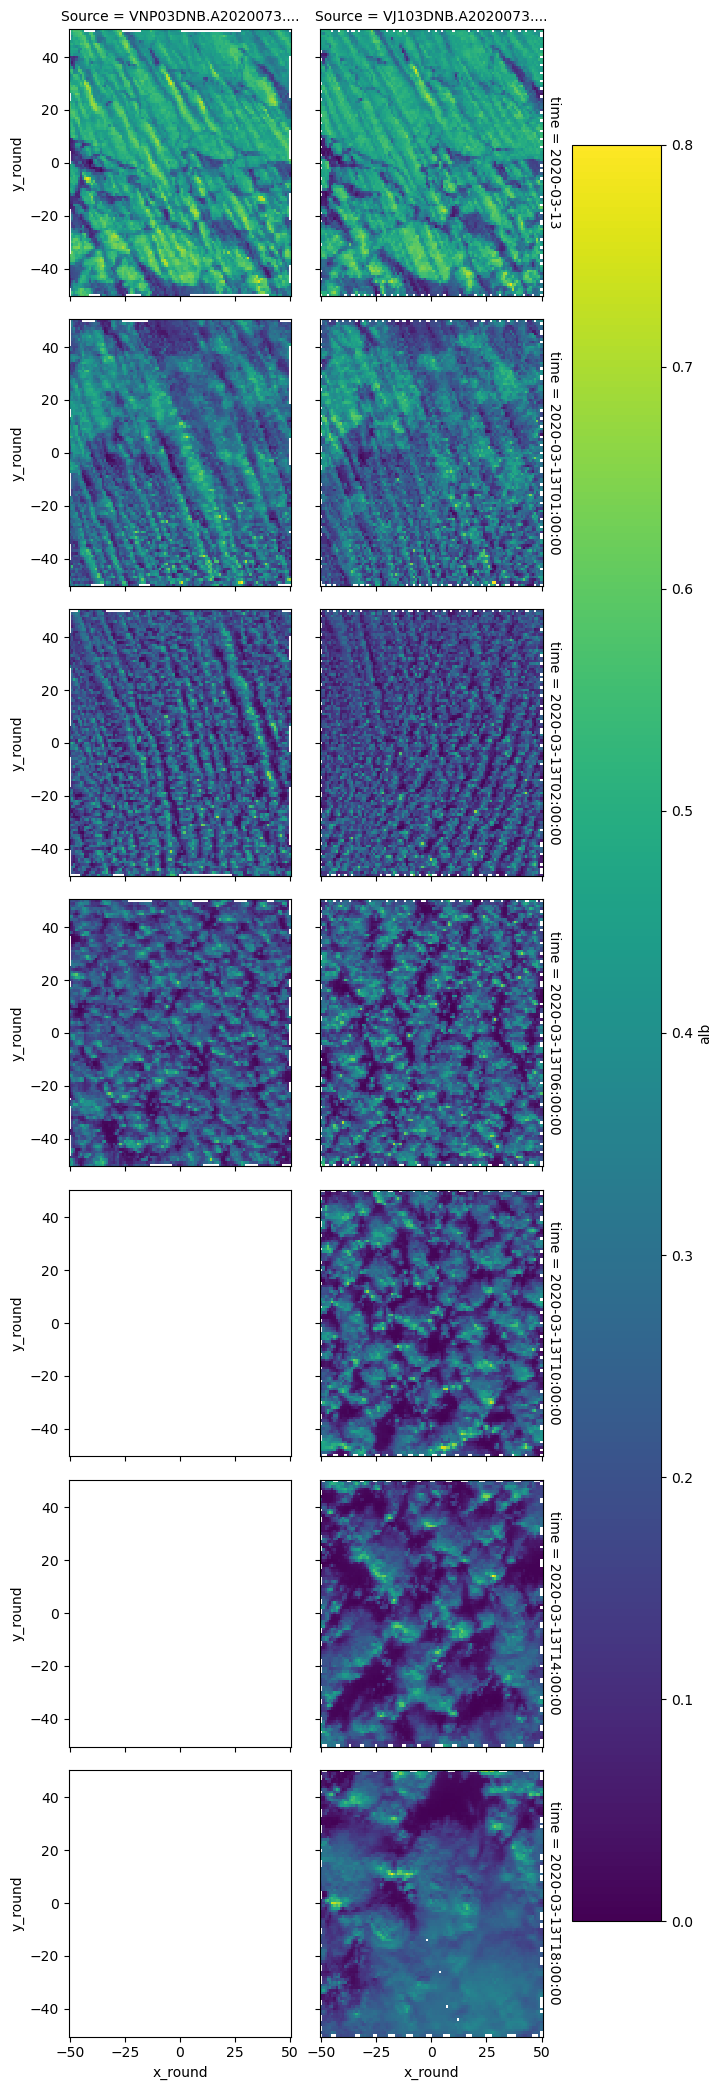

In [6]:
da_stat_ststst.plot(row='time',col='Source')

In [7]:
os.chdir("/user-data-home/comble-mip/notebooks/plotting/")
%run functions_plotting.py 

var_vec_2d = ['alb','opt']

## load all simulations located in subfolders of the given directory
df_col_2d = load_sims_2d('/data/project/comble-mip/output_les/',var_vec_2d,t_shift=-2,keyword=sim_keyword,times=[t for t in Time_Vec if t > 0],coarsen=True)

Loading variables: f(time,x,y)
/data/project/comble-mip/output_les/wrf/WRF_Lx25_dx100_FixN_2D.nc


ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed


NaN values in alb
NaN values in opt
/data/project/comble-mip/output_les/dharma/DHARMA_Lx25_dx100_FixN_2D.nc
/data/project/comble-mip/output_les/uclales-salsa/UCLALES-SALSA_Lx25_dx100_FixN_2D.nc
...adjusting x and y values


In [8]:
#df_col_2d['alb'].plot(row='time',col_wrap=7,col='Source')

/tmp/ipykernel_134/3852338689.py:1: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  xr.merge([df_col_2d['alb'],da_stat_ststst.drop('time_diff')])['alb'].plot(row='time',col='Source')


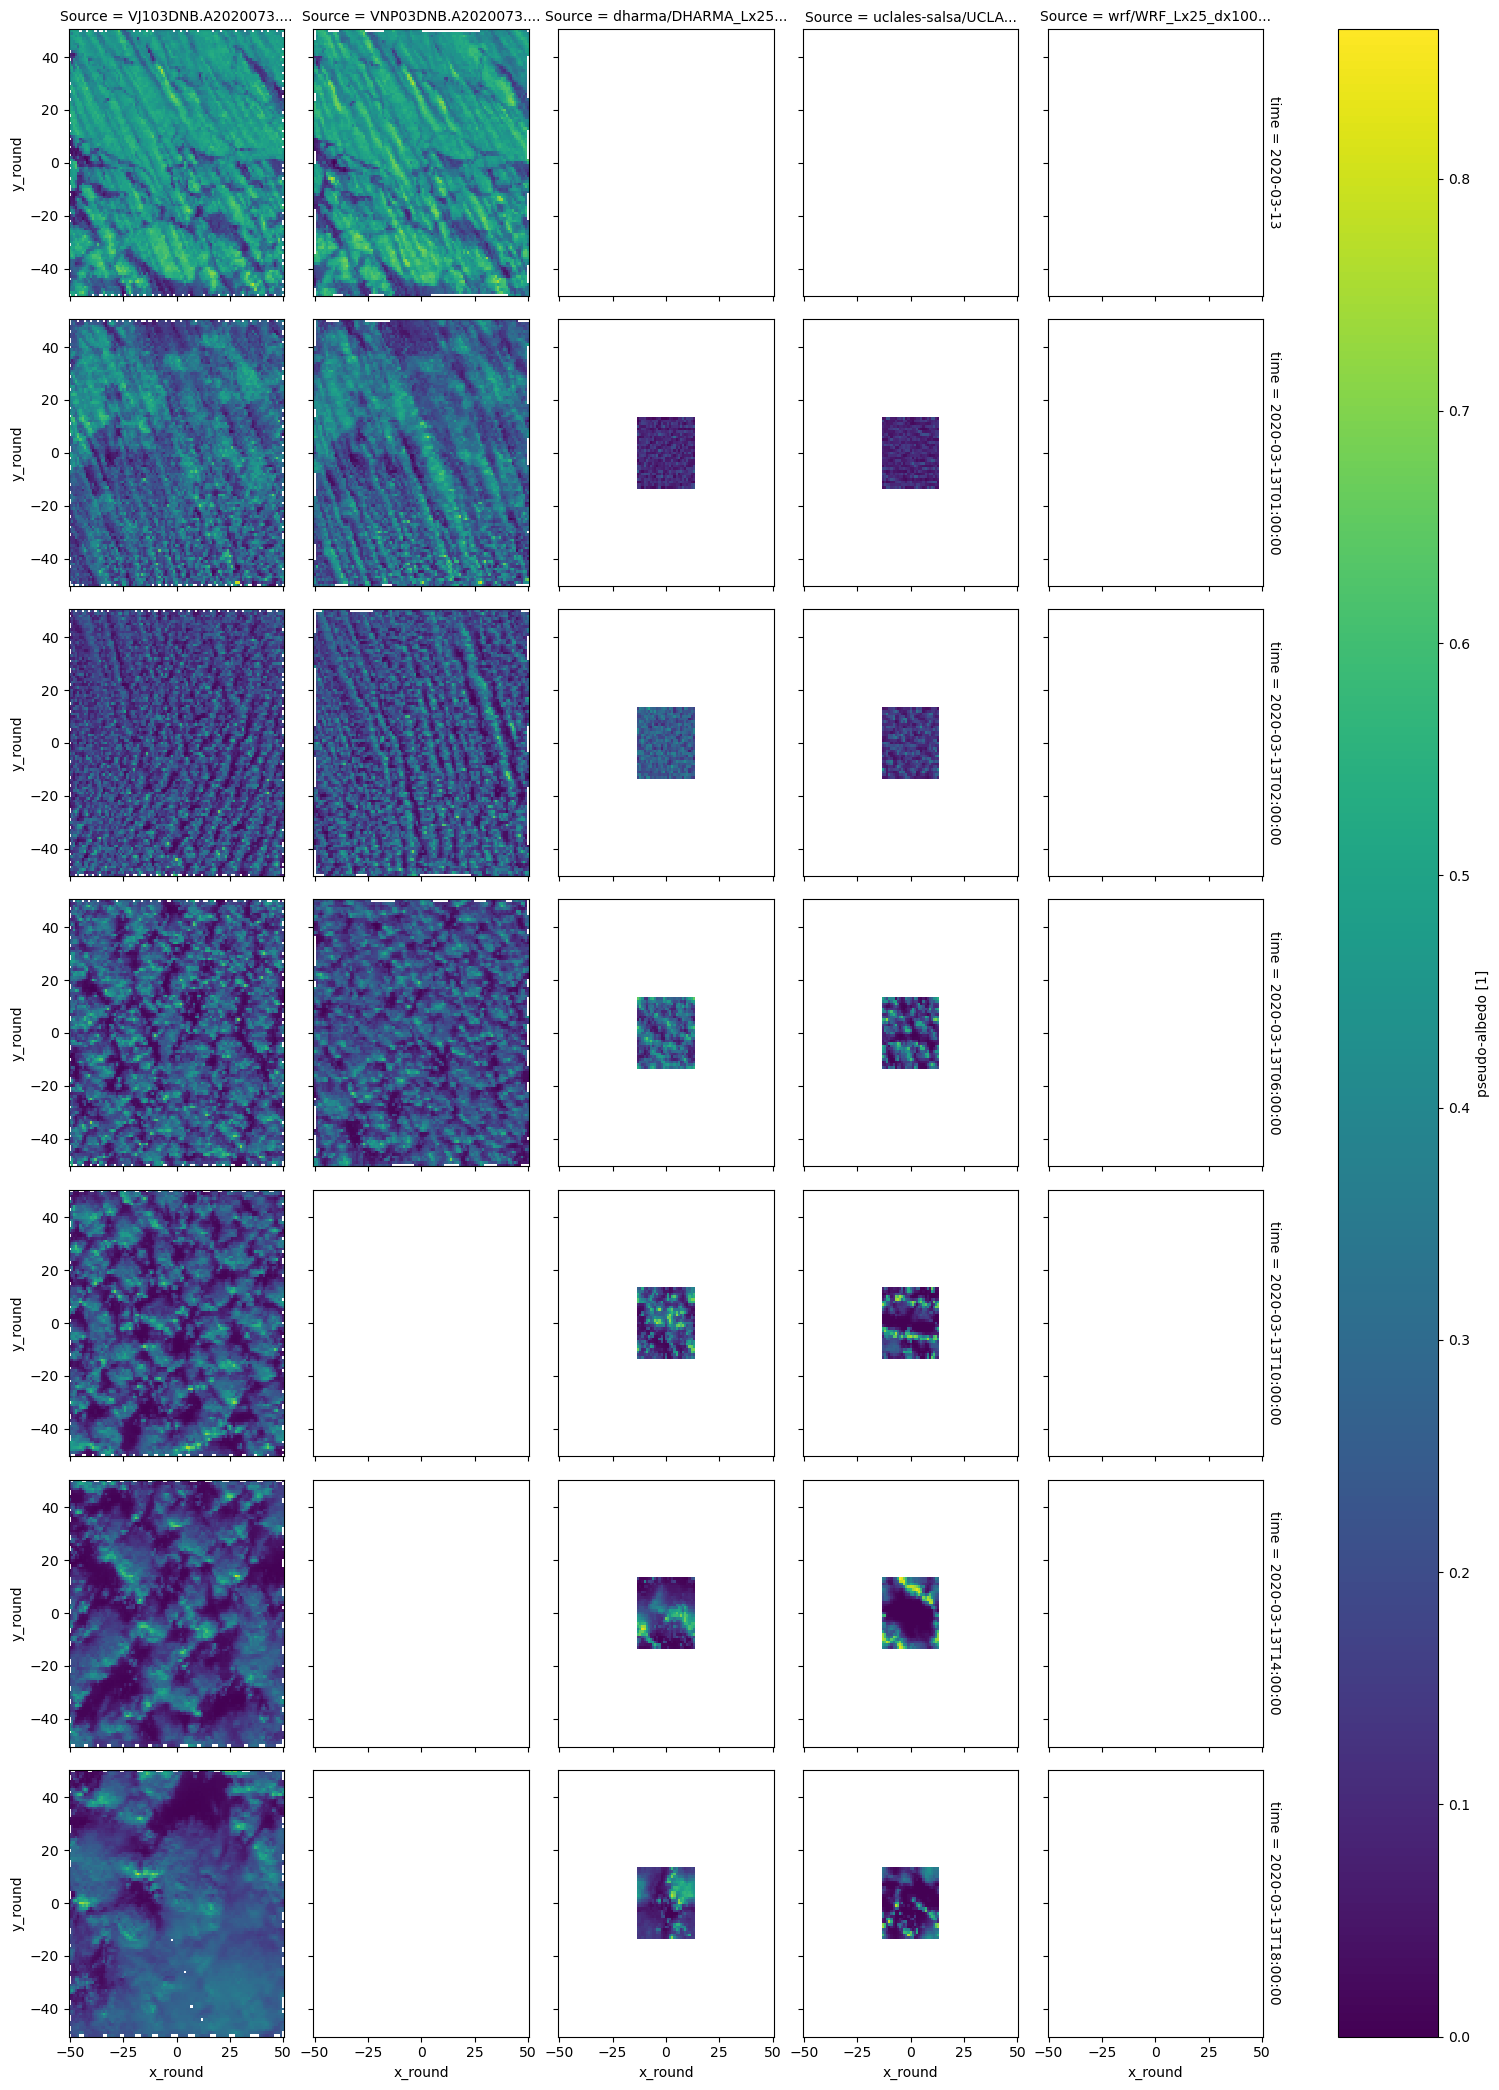

In [9]:
xr.merge([df_col_2d['alb'],da_stat_ststst.drop('time_diff')])['alb'].plot(row='time',col='Source')

In [169]:
xr.merge([df_col_2d['alb'],da_stat_ststst.drop_vars('time_diff')]).isel(Source=3)

<xarray.Dataset> Size: 573kB
Dimensions:  (x_round: 101, time: 7, y_round: 101)
Coordinates:
  * x_round  (x_round) float64 808B -50.0 -49.0 -48.0 -47.0 ... 48.0 49.0 50.0
  * time     (time) datetime64[ns] 56B 2020-03-13 ... 2020-03-13T18:00:00
    Source   <U49 196B 'uclales-salsa/UCLALES-SALSA_Lx25_dx100_FixN_2D.nc'
  * y_round  (y_round) float64 808B -50.0 -49.0 -48.0 -47.0 ... 48.0 49.0 50.0
Data variables:
    alb      (y_round, x_round, time) float64 571kB nan nan nan ... nan nan nan
Attributes:
    units:      1
    long_name:  pseudo-albedo

In [98]:
df_col_2d_tot.isel(Source=0)

<xarray.Dataset> Size: 573kB
Dimensions:  (x_round: 101, time: 7, y_round: 101)
Coordinates:
  * x_round  (x_round) float64 808B -50.0 -49.0 -48.0 -47.0 ... 48.0 49.0 50.0
  * time     (time) datetime64[ns] 56B 2020-03-13 ... 2020-03-13T18:00:00
    Source   <U49 196B 'VJ103DNB.A2020073.1212'
  * y_round  (y_round) float64 808B -50.0 -49.0 -48.0 -47.0 ... 48.0 49.0 50.0
Data variables:
    alb      (y_round, x_round, time) float64 571kB nan nan ... 0.09552 0.1255
Attributes:
    units:      1
    long_name:  pseudo-albedo

In [175]:
df_col_2d_tot.isel(Source=ss)['time'].isel(time=tt)

<xarray.DataArray 'time' ()> Size: 8B
array('2020-03-13T18:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 8B 2020-03-13T18:00:00
    Source   <U49 196B 'dharma/DHARMA_Lx25_dx100_FixN_2D.nc'
Attributes:
    long_name:  time

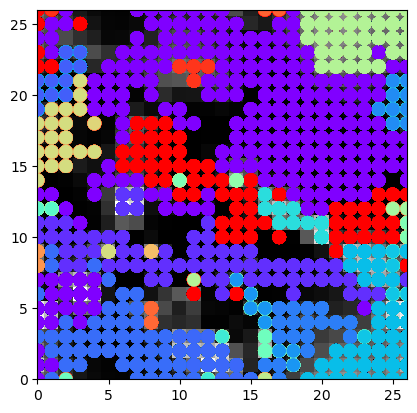

17_17
1_1
2_2
3_3
4_4
5_5
6_6
7_7
8_8
9_9
10_10
11_11
12_12
13_13
14_14
15_15
16_16
                slope  intercept      area                time  \
cluster                                                          
1        3.469425e-01  -4.779169  0.054870 2020-03-13 18:00:00   
2        1.890392e-02  23.803503  0.048011 2020-03-13 18:00:00   
3        1.010830e+00   2.581227  0.020576 2020-03-13 18:00:00   
4       -5.000000e-01   7.615385  0.017833 2020-03-13 18:00:00   
5       -4.529412e-01  19.547059  0.012346 2020-03-13 18:00:00   
6       -3.296171e-15  12.500000  0.005487 2020-03-13 18:00:00   
7        4.615380e-15  21.750000  0.005487 2020-03-13 18:00:00   
8        0.000000e+00  24.666667  0.004115 2020-03-13 18:00:00   
9        1.556420e-01   0.009728  0.002743 2020-03-13 18:00:00   
10       0.000000e+00   8.500000  0.002743 2020-03-13 18:00:00   
11       5.538462e-01   0.069231  0.002743 2020-03-13 18:00:00   

                                                    Sourc

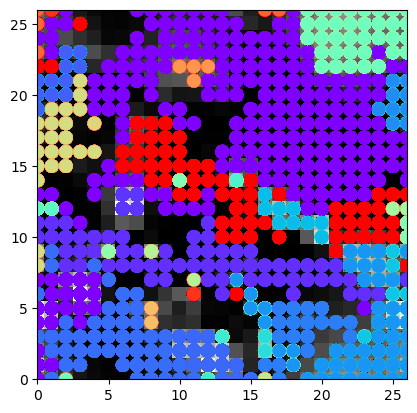

In [176]:
import os, sys, tarfile
from pathlib import Path
import netCDF4 as nc
from numpy import *
import matplotlib.pyplot as plt
import glob
import pandas as pd
## test to apply clustering algorithm ###

## certain properties
RES_ORG = 0.1
RES_CLA = 1.0

## use both obs and LES
df_col_2d_tot = xr.merge([df_col_2d,da_stat_ststst.drop_vars('time_diff')])

## certain thresholds
counter = 0
for ss in [2,3]:
    print(df_col_2d_tot.isel(Source=ss)['Source'].data)
    print('-----')
    tt_vec = len(df_col_2d_tot.isel(Source=ss)['time'])
    for tt in range(4,tt_vec):
        pseudo_alb = df_col_2d_tot['alb'].isel(time=tt).isel(Source=ss).data
        pseudo_alb[np.isnan(pseudo_alb)] = 0

        #if 'opt' in df_col_2d_tot.isel(Source=ss).keys():
        if sum(np.isnan(df_col_2d_tot.isel(Source=ss)['opt']) == 0):
            pseudo_alb  = df_col_2d_tot['alb'].isel(time=tt).isel(Source=ss).sel(x_round=slice(np.min(df_col_2d['x_round']),np.max(df_col_2d['x_round']))).sel(y_round=slice(np.min(df_col_2d['y_round']),np.max(df_col_2d['y_round']))).data
            opd_cloud  = df_col_2d_tot['opt'].isel(time=tt).isel(Source=ss).sel(x_round=slice(np.min(df_col_2d['x_round']),np.max(df_col_2d['x_round']))).sel(y_round=slice(np.min(df_col_2d['y_round']),np.max(df_col_2d['y_round']))).data
            
            THRES_CONNECT = np.nanquantile(pseudo_alb[(opd_cloud) > 2.0],0.50)
            THRES_CLOUD   = np.nanquantile(pseudo_alb[(opd_cloud) > 2.0],0.50)
        else:
            print('here!')
            THRES_CONNECT = np.nanquantile(pseudo_alb,0.50)
            THRES_CLOUD   = np.nanquantile(pseudo_alb,0.50)
        print(THRES_CONNECT)
        print(THRES_CLOUD)
        
        if sum(pseudo_alb > THRES_CLOUD) > 1:
            CLUST_COORDS = id_watershed(pseudo_alb,THRES_CLOUD,THRES_CONNECT,plotting=True)
            CLUST_GEOM = cluster_geometry(CLUST_COORDS,total=[(shape(pseudo_alb)[0]*shape(pseudo_alb)[1])])
            CLUST_GEOM['time']   = df_col_2d_tot.isel(time=tt).isel(Source=ss)['time'].data
            CLUST_GEOM['Source'] = df_col_2d_tot.isel(time=tt).isel(Source=ss)['Source'].data
            print(CLUST_GEOM)
            if counter == 0:
                CLUST_GEOM_COL = pd.concat([CLUST_GEOM])
            else:
                CLUST_GEOM_COL = pd.concat([CLUST_GEOM_COL,CLUST_GEOM])
            counter +=1
    
## coarsen field
#var_coarse = coarsen_2d(pseudo_alb,RES_CLA=RES_CLA,RES_ORG=RES_ORG)
#nx_coa = var_coarse.shape[0]


#plt.imshow(df_col_2d['alb'].isel(time=3).isel(Source=1).data)

In [177]:
CLUST_GEOM_COL

,slope,intercept,area,time,Source
cluster,,,,,
1,-5.557001e-01,23.054708,0.240055,2020-03-13 10:00:00,dharma/DHARMA_Lx25_dx100_FixN_2D.nc
2,-2.608696e-01,30.108696,0.030178,2020-03-13 10:00:00,dharma/DHARMA_Lx25_dx100_FixN_2D.nc
3,-2.594810e-02,4.003992,0.021948,2020-03-13 10:00:00,dharma/DHARMA_Lx25_dx100_FixN_2D.nc
4,-1.605263e+00,30.615789,0.020576,2020-03-13 10:00:00,dharma/DHARMA_Lx25_dx100_FixN_2D.nc
5,1.818182e-01,7.363636,0.005487,2020-03-13 10:00:00,dharma/DHARMA_Lx25_dx100_FixN_2D.nc
1,-3.475974e-01,18.364211,0.174211,2020-03-13 14:00:00,dharma/DHARMA_Lx25_dx100_FixN_2D.nc
2,-8.960436e-01,9.320685,0.079561,2020-03-13 14:00:00,dharma/DHARMA_Lx25_dx100_FixN_2D.nc
1,-1.216006e-01,20.808542,0.190672,2020-03-13 18:00:00,dharma/DHARMA_Lx25_dx100_FixN_2D.nc
2,-8.306709e-02,18.591054,0.042524,2020-03-13 18:00:00,dharma/DHARMA_Lx25_dx100_FixN_2D.nc


In [16]:
cluster_geometry(CLUST_COORDS,total=[(shape(pseudo_alb)[0]*shape(pseudo_alb)[1])])

,slope,intercept,area
cluster,,,
1,3.469425e-01,-4.779169,0.054870
2,1.890392e-02,23.803503,0.048011
3,1.010830e+00,2.581227,0.020576
4,-5.000000e-01,7.615385,0.017833
5,-4.529412e-01,19.547059,0.012346
6,-3.296171e-15,12.500000,0.005487
7,4.615380e-15,21.750000,0.005487
8,0.000000e+00,24.666667,0.004115
9,1.556420e-01,0.009728,0.002743


In [263]:
CLUST_GEOM_COL['time_conv'] = (pd.to_datetime(CLUST_GEOM_COL['time']) - pd.to_datetime('2020-03-12 22:00:00')).astype('timedelta64[h]')

In [ ]:
#p#lt.hist(CLUST_GEOM_COL['area'],label=CLUST_GEOM_COL['Source'])

CLUST_GEOM_COL.groupby('Source')['area'].hist(alpha=0.75)

In [265]:
CLUST_STAT_1 = CLUST_GEOM_COL.groupby(['Source','time_conv'])['area'].size()
CLUST_STAT_2 = CLUST_GEOM_COL.groupby(['Source','time_conv'])['area'].max()

In [266]:
CLUST_STAT_1

Source                                             time_conv
dharma/DHARMA_Lx25_dx100_FixN_2D.nc                12.0          5
                                                   16.0          2
                                                   20.0          5
uclales-salsa/UCLALES-SALSA_Lx25_dx100_FixN_2D.nc  12.0         12
                                                   16.0          7
                                                   20.0         11
Name: area, dtype: int64

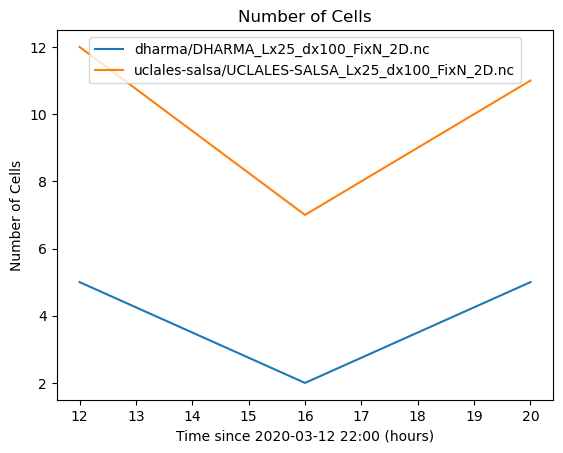

In [276]:
for name,j in CLUST_STAT_1.groupby('Source'):
    j[name].plot(title='Number of Cells',xlabel='Time since 2020-03-12 22:00 (hours)',ylabel='Number of Cells',label=name,legend=True)

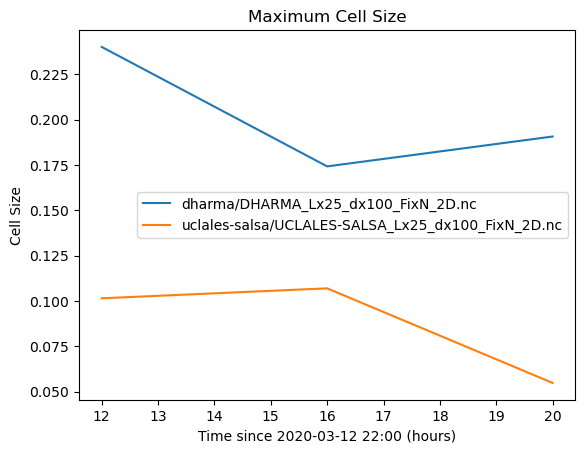

In [278]:
for name,j in CLUST_STAT_2.groupby('Source'):
    j[name].plot(title='Maximum Cell Size',xlabel='Time since 2020-03-12 22:00 (hours)',ylabel='Cell Size',label=name,legend=True)

In [357]:
CLUST_GEOM_COL['Clust'] = CLUST_GEOM_COL.index 

dharma/DHARMA_Lx25_dx100_FixN_2D.nc
dharma/DHARMA_Lx25_dx100_FixN_2D.nc
dharma/DHARMA_Lx25_dx100_FixN_2D.nc
uclales-salsa/UCLALES-SALSA_Lx25_dx100_FixN_2D.nc
uclales-salsa/UCLALES-SALSA_Lx25_dx100_FixN_2D.nc
uclales-salsa/UCLALES-SALSA_Lx25_dx100_FixN_2D.nc


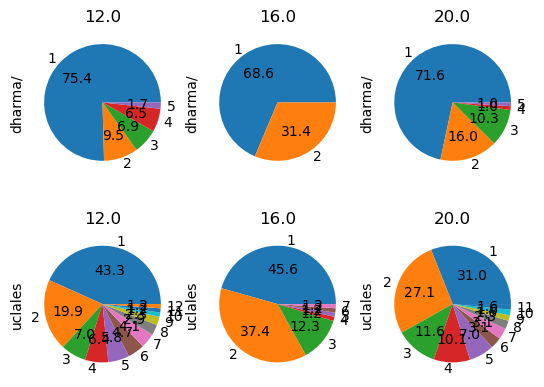

In [356]:
fig, axes = plt.subplots(nrows=2, ncols=3)
for ax, col in zip(axes.flat, CLUST_GEOM_COL.groupby(['Source','time_conv'])):
    print(col[0][0])
    model = col[0][0][0:7]
    time = col[0][1]
    ax.pie(col[1]['area'],labels=col[1].index,autopct='%.1f',)
    ax.set(ylabel=model, title=time, aspect='equal')



/tmp/ipykernel_134/256441689.py:3: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for s, g in CLUST_GEOM_COL.groupby(['Source']):
/tmp/ipykernel_134/256441689.py:4: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for t, f in g.groupby(['time']):
/tmp/ipykernel_134/256441689.py:4: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for t, f in g.groupby(['time']):


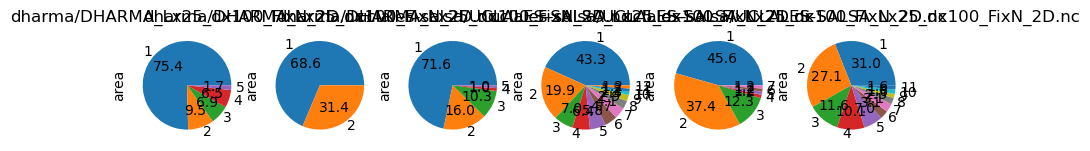

In [295]:

fig, ax = plt.subplots(1, 6, figsize=(10,8))
ax = iter(ax)
for s, g in CLUST_GEOM_COL.groupby(['Source']):
    for t, f in g.groupby(['time']):
        #print(f)
        f.set_index('Clust')['area'].plot.pie(ax=next(ax),  autopct='%.1f', title=f'{s}')

/tmp/ipykernel_134/766387201.py:3: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for t, g in CLUST_GEOM_COL.groupby(['Source']):


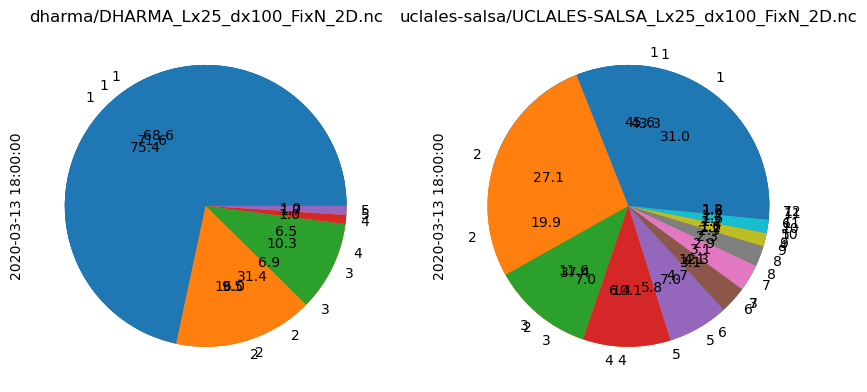

In [310]:

fig, ax = plt.subplots(1, 2, figsize=(10,8))
ax = iter(ax)
for t, g in CLUST_GEOM_COL.groupby(['Source']):
    g.set_index('Clust').groupby('time')['area'].plot.pie(ax=next(ax),  autopct='%.1f', title=f'{t}')

In [ ]:

CLUST_COORDS_BIG = CLUST_COORDS.copy()


CLUST_COORDS_BIG['x'] = (CLUST_COORDS['x']*RES_CLA/RES_ORG) + (RES_CLA/RES_ORG - 1)/2
CLUST_COORDS_BIG['y'] = (CLUST_COORDS['y']*RES_CLA/RES_ORG) + (RES_CLA/RES_ORG - 1)/2

    
CLUST_GEOM = cluster_geometry(CLUST_COORDS_BIG,total=[(shape(pseudo_alb)[0]*shape(pseudo_alb)[1])])
CLUST_GEOM['time'] = 1
pd.concat([CLUST_GEOM,CLUST_GEOM])

In [ ]:
plt.scatter(CLUST_GEOM.index,CLUST_GEOM.area)

In [ ]:

## select simulations to plot
sim_keyword = 'DHARMA_Lx25_dx100_FixN_2D' #UCLALES-SALSA_Lx25_dx100_FixN_2D'  

os.chdir("/user-data-home/comble-mip/notebooks/plotting/")
%run functions_plotting.py 

## load all simulations located in subfolders of the given directory
df_col_2d = load_sims_2d('/data/project/comble-mip/output_les/',var_vec_2d,t_shift=-2,keyword=sim_keyword,times=[t for t in Time_Vec if t > 0],coarsen=True)
var_vec_2d = ['olr11']

df_col_2d['olr11'].plot(row='time',col_wrap=7,col='Source')

In [ ]:
df_col_2d['olr11'].isel(time=0)